In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# **Exercise 1**

The following table presents the results of a study on the probability of occurrence of a disease A, taking into account the absence / presence of factors X1, X2 and X3 (Xi = 0 means the absence of factor Xi, Xi = 1 means the presence of factor Xi, i = 1,2,3).

$$
\begin{array}{|c|c|c|c|c|}
\hline
X1 & X2 & X3 & \text{SUBJECTS OF THE STUDY} & \text{SUBJECTS WITH DISEASE A} \\
\hline
0 & 0 & 0 & 90 & 27 \\
0 & 0 & 1 & 67 & 24 \\
0 & 1 & 0 & 53 & 21 \\
0 & 1 & 1 & 48 & 33 \\
1 & 0 & 0 & 58 & 42 \\
1 & 0 & 1 & 55 & 45 \\
1 & 1 & 0 & 69 & 56 \\
1 & 1 & 1 & 85 & 65 \\
\hline
\end{array}
$$

1) Given that the assumptions for its application are valid, provide an appropriate model for predicting the occurrence of disease A and interpret the coefficients of the model.
2) Calculate the predictions of the model for all possible combinations of the factors X1, X2 and X3. Which are the deviations of these predictions from the experimental data?


## Question 1

This data can be modeled using logistic regression since the outcome variable, occurrence of disease A, is binary (0/1). The goal is to estimate the probability of disease A occurring given the set of risk factors X1, X2, and X3.

The logistic regression model relates the log odds of the outcome to a linear combination of the predictors:

$\log(\frac{P(y=1|x)}{P(y=0|x)}) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_3$

Where P(y=1|x) is the probability of disease A occurring given the risk factors. The β coefficients represent the log odds ratio for a one unit increase in the respective predictor.

Positive coefficients indicate the predictor increases the odds of disease A, while negative values decrease the odds. Larger absolute coefficients mean the variable has a stronger influence on the probability of disease occurrence.

The probability of disease is modeled by the logistic function:

$P(y=1|x) = \frac{1}{1+e^{-(β_0 + β_1X_1 + β_2X_2 + \beta_3X_3)}}$

By fitting the model, we can estimate the β coefficients to assess the relationship between each factor and the probability of disease A. However, care must be taken with interpretation due to possible confounding.

Because the SUBJECTS OF THE STUDY and the SUBJECTS WITH DISEASE A values are give, we can also find the probabilites of someone to have the disease A. 

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
X1 & X2 & X3 & \text{SUBJECTS OF THE STUDY} & \text{SUBJECTS WITH DISEASE A} & \text{Probabilities} \\
\hline
0 & 0 & 0 & 90 & 27 & 0.3 \\
0 & 0 & 1 & 67 & 24 & 0.35\\
0 & 1 & 0 & 53 & 21 & 0.39\\
0 & 1 & 1 & 48 & 33 & 0.68\\
1 & 0 & 0 & 58 & 42 & 0.72\\
1 & 0 & 1 & 55 & 45 & 0.81\\
1 & 1 & 0 & 69 & 56 & 0.81\\
1 & 1 & 1 & 85 & 65 & 0.76\\
\hline
\end{array}
$$


In [2]:
data = {
    'X1': [0, 0, 0, 0, 1, 1, 1, 1],
    'X2': [0, 0, 1, 1, 0, 0, 1, 1],
    'X3': [0, 1, 0, 1, 0, 1, 0, 1],
    'SUBJECTS_OF_THE_STUDY': [90, 67, 53, 48, 58, 55, 69, 85],
    'SUBJECTS_WITH_DISEASE_A': [27, 24, 21, 33, 42, 45, 56, 65]
}

df = pd.DataFrame(data)

df['PROBABILITIES'] = df['SUBJECTS_WITH_DISEASE_A'] / df['SUBJECTS_OF_THE_STUDY']

print(df[['X1', 'X2', 'X3', 'PROBABILITIES']])


   X1  X2  X3  PROBABILITIES
0   0   0   0       0.300000
1   0   0   1       0.358209
2   0   1   0       0.396226
3   0   1   1       0.687500
4   1   0   0       0.724138
5   1   0   1       0.818182
6   1   1   0       0.811594
7   1   1   1       0.764706


In [3]:
# Create a binary outcome (1 if disease A is present, 0 otherwise) for logistic regression
# Repeating rows for 'SUBJECTS_WITH_DISEASE_A' times with outcome 1
# and 'SUBJECTS_OF_THE_STUDY' - 'SUBJECTS_WITH_DISEASE_A' times with outcome 0
diseased = df.loc[df.index.repeat(df['SUBJECTS_WITH_DISEASE_A'])].copy()
diseased['Outcome'] = 1

healthy = df.loc[df.index.repeat(df['SUBJECTS_OF_THE_STUDY'] - df['SUBJECTS_WITH_DISEASE_A'])].copy()
healthy['Outcome'] = 0

df_expanded = pd.concat([diseased, healthy])
df_expanded.head()

,X1,X2,X3,SUBJECTS_OF_THE_STUDY,SUBJECTS_WITH_DISEASE_A,PROBABILITIES,Outcome
0,0,0,0,90,27,0.3,1
0,0,0,0,90,27,0.3,1
0,0,0,0,90,27,0.3,1
0,0,0,0,90,27,0.3,1
0,0,0,0,90,27,0.3,1


In [4]:
X = df_expanded[['X1', 'X2', 'X3']]
X = sm.add_constant(X)  # Add the intercept term (b0)
y = df_expanded['Outcome']

model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.589761
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  525
Model:                          Logit   Df Residuals:                      521
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Sep 2023   Pseudo R-squ.:                  0.1257
Time:                        11:53:30   Log-Likelihood:                -309.62
converged:                       True   LL-Null:                       -354.13
Covariance Type:            nonrobust   LLR p-value:                 3.585e-19
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7612      0.175     -4.347      0.000      -1.104      -0.418
X1             1.5497      0.

## Question 2

Using the fitted logistic regression model, predictions can be generated for all 8 possible combinations of the risk factors X1, X2, and X3. These predicted probabilities can then be compared to the experimental probabilities calculated directly from the provided data.

In [5]:
combinations = pd.DataFrame({
    'X1': [0, 0, 0, 0, 1, 1, 1, 1],
    'X2': [0, 0, 1, 1, 0, 0, 1, 1],
    'X3': [0, 1, 0, 1, 0, 1, 0, 1]
})

In [6]:
X_combinations = sm.add_constant(combinations) 
predicted_probabilities = result.predict(X_combinations)

In [7]:
experimental_probabilities = [27/90, 24/67, 21/53, 33/48, 42/58, 45/55, 56/69, 65/85]

deviations = predicted_probabilities - experimental_probabilities

for i, (index, row) in enumerate(combinations.iterrows()):
    print(f"Combination {row['X1'], row['X2'], row['X3']}: Deviation = {deviations[i]:.4f}")

Combination (0, 0, 0): Deviation = 0.0184
Combination (0, 0, 1): Deviation = 0.0506
Combination (0, 1, 0): Deviation = 0.0421
Combination (0, 1, 1): Deviation = -0.1515
Combination (1, 0, 0): Deviation = -0.0366
Combination (1, 0, 1): Deviation = -0.0531
Combination (1, 1, 0): Deviation = -0.0255
Combination (1, 1, 1): Deviation = 0.0800


**Results:**

Deviations between the predicted and experimental probabilities provide insights into how well the model fits the observed data. Positive deviations indicate the model overestimates the probability of disease A relative to the empirical data for that combination. Negative deviations arise when the model underestimates the probability compared to the observed data.

For the combinations (0,0,0), (0,0,1), (0,1,0), and (1,1,1), the model provides higher predicted probabilities than the actual data, with positive deviations ranging from 0.0184 to 0.08.

In contrast, the combinations (0,1,1), (1,0,0), (1,0,1), and (1,1,0) have negative deviations, meaning the model predicts lower probabilities than empirically observed. The largest underestimate occurs for (0,1,1) where the model probability is 0.1515 below the experimental value.

While some deviation is expected due to randomness, the larger mismatches for certain combinations suggest the logistic model may not fully capture potential interactions between the risk factors. Additional terms or non-linear relationships may need to be considered to improve calibration between predicted and observed probabilities.

# **Exercise 2**

In an experiment the values of biological characteristics x and y were studied. The results of the (independent) measurements are listed in the following table:

$$
\begin{array}{|c|c|c|c|c|c|c|c|c|c|c|}
\hline
X & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & 11 \\
\hline
Y & 8 & 18 & 19 & 24 & 33 & 30 & 40 & 50 & 40 & 56 \\
\hline
\end{array}
$$

1) Find the linear relationship between the characteristics x and y when the characteristic x is the independent variable.
2) Find the linear relationship between the characteristics x and y when the characteristic y is the independent variable.
3) Based on the relation of question 1, predict the value of characteristic y when characteristic x receives the values of 5.5 and 13.5.
3) Based on the relation of question a, test at the 5% significance level the hypothesis that the variable y is not linearly dependent on the variable x.

*Hint: Provide analytically the assumptions to apply the linear regression and check their validity.*


## Question 1

To assess the linear relationship between characteristics x and y, with x as the independent variable, I will fit a simple linear regression model predicting y from x. This involves several key assumptions:

- The observations are independent
- The true relationship is linear
- The residuals (errors) follow a normal distribution
- The residuals exhibit constant variance

In [8]:
x = np.array([2,3,4,5,6,7,8,9,10,11])
y = np.array([8,18,19,24,33,30,40,50,40,56])

Visually, the data appears to demonstrate a linear trend. To formally evaluate the assumptions, I will analyze the residuals from the fitted model.

*Overview of Residual Analysis*

- Through residual analysis, we scrutinize the distribution of residuals and their correlations with predictor variables. This helps verify if the model's underlying assumptions, vital for linear regression's validity, are met.
- Mathematically, the residuals $e$ capture the discrepancy between the observed dependent variable values and the values predicted using linear regression. Formally, the residual for a given data point is given by:  $e_i = y-y_i$
Where: $y_i=a+bx$
Here,$y$ is the observed value and $y_i$ is the predicted value for the i-th observation.

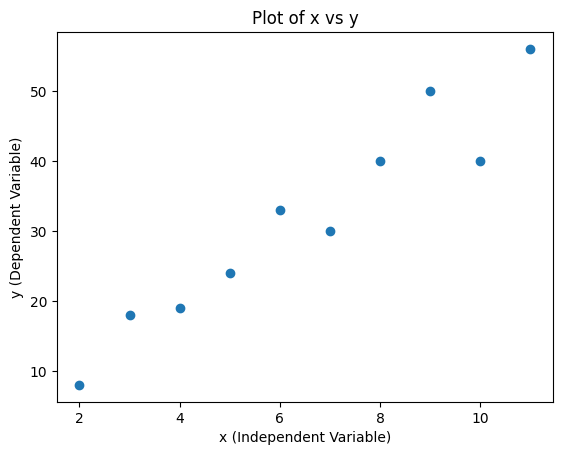

In [9]:
plt.scatter(x, y)
plt.xlabel("x (Independent Variable)")
plt.ylabel("y (Dependent Variable)")
plt.title("Plot of x vs y")
plt.show()

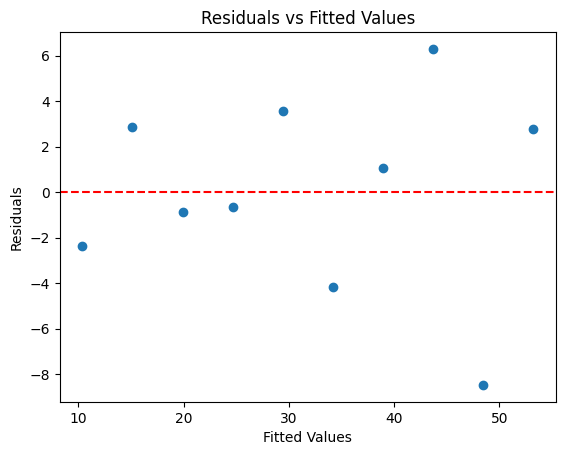

In [10]:
X_const = sm.add_constant(x)
model_1 = sm.OLS(y, X_const).fit()
fitted_values = model_1.predict(X_const)
residuals = model_1.resid

plt.scatter(fitted_values, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

Utilizing the Least Squares Estimation (LSE), I determined the  $y_{est}$  and subsequently computed the residuals. Notably, these residuals are uniformly scattered both above and below the red line indicating zero difference. This consistent distribution suggests that the data exhibits linearity. As a result, there's no necessity for curve regression to achieve an apt fit.

*The standardized residuals:*

The residuals are standardized to possess a mean of 0 and a standard deviation of 1. This standardization process highlights the relative positioning of each observation in terms of standard deviations from the mean. To calculate standardized residuals, we simply divide the residuals by their estimated standard deviation.

In [11]:
X = x.reshape(-1, 1)
Y = y.reshape(-1, 1)
n = X.shape[0]
p = 2 
H = X@np.linalg.inv(X.T@X)@X.T

In [12]:
temp=0
standres = []
for res_i in residuals:
    standres.append(res_i/(np.sqrt(np.sum(residuals**2)*(1-np.diag(H)[temp])/(n-p))))
    temp+=1

In [13]:
standres = np.array(standres)
standres

array([-0.52175355,  0.63731945, -0.19905935, -0.14761239,  0.81718564,
       -0.96757878,  0.24811306,  1.50950339, -2.08017239,  0.69681726])

If residuals are approximately normally distributed, about 95% of the standardized residuals should lie between -2 and 2. In our case, 90% of the values fall within this range. While this doesn't precisely match the expectations of Q-Q plots for normality, it's crucial to recognize that in a dataset of merely 10 data points, a single outlier can heavily skew the normality perception, accounting for 10% of the data. Nonetheless, as all values reside within the -2.58 to 2.58 interval, it strengthens our belief that the Q-Q plot results indeed suggest the data is approximately normal.

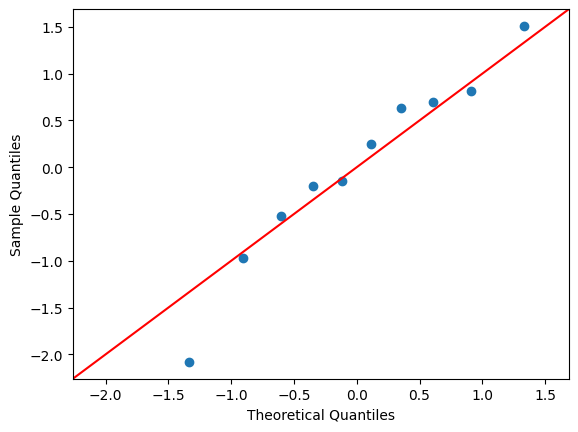

In [14]:
sm.qqplot(standres, line='45')
plt.show()

*The studentized residuals:*

The standardized residuals are calculated by dividing all residuals by the same number. However, their variance is not constant for all data points but depends on the location of these points. Residuals corresponding to the area of the sample mean have less variance than those corresponding to an area away from the sample mean. The transformation into the studentized residuals leads (as long as the regression assumptions hold) to residuals with the same variance for all data points.
Studentized residuals account for this heteroscedasticity by scaling each residual by its estimated standard deviation $s_i$, excluding the $i$th observation:

$t_i = \frac{e_i}{\sqrt{s_i(1-h_{ii})}}$

Where $h_{ii}$ is the i-th diagonal value from the matrix $H=X(X^TX)^{-1}X^T$ and $s_i=\frac{|e^2|}{n-p-1}-\frac{e_i^2}{(n-p-1)(1-h_{ii})}$ and $e_i$ is the residual of the i-th datapoint.

To test this assumption, we can compare each studentized residual $t_i$ to the Student's t distribution with n-p-1 degrees of freedom (in this occation df=8), where n is the sample size and p is the number of coefficients. The null hypothesis is that the residuals exhibit constant variance.



In [15]:
temp = 0
t = []
s = []
for res_i in residuals:
    s_i = sum(residuals**2)/(n-p-1)-res_i**2/((n-p-1)*(1-np.diag(H)[temp]))
    s.append(s_i)
    t.append(res_i/(np.sqrt(s_i*(1-np.diag(H)[temp]))))
    temp+=1 

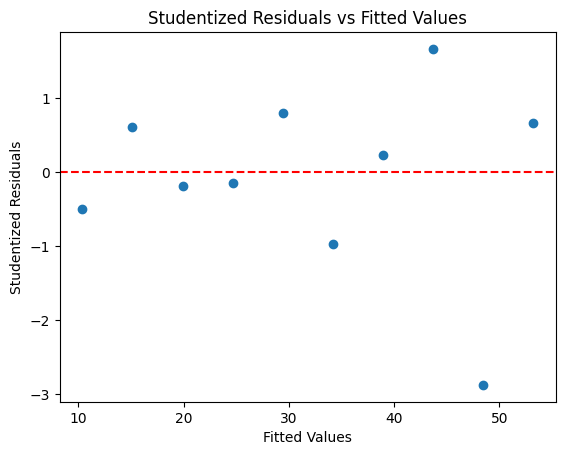

In [16]:
plt.scatter(fitted_values, t)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Studentized Residuals")
plt.title("Studentized Residuals vs Fitted Values")
plt.show()

In this case with 8 degrees of freedom, most t_i fall within the 95% confidence bounds of [-2.306, 2.306], failing to reject the null hypothesis. However, one high outlier suggests potential heteroscedasticity. Given the small sample size of 10, I will retain this outlier rather than discard 10% of the data. The model appears to adequately fit the majority of observations, which is reasonable with such limited data.

Removing the outlier could improve model fit, but the sample is too small to confidently exclude observations. Overall, the linear model assumptions seem largely satisfied by the bulk of the data.

Since all the assumptions are met: 

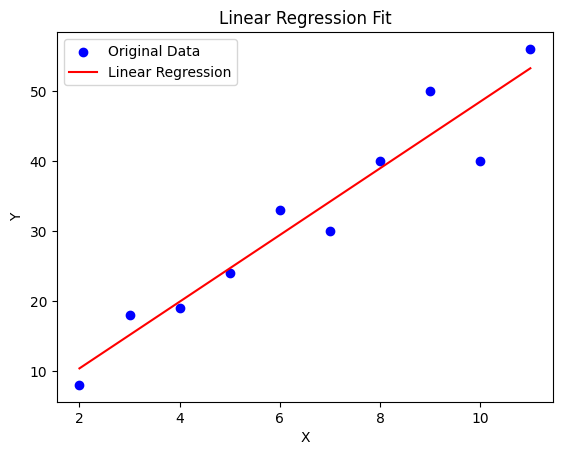

In [17]:
plt.scatter(X, Y, color='blue', label='Original Data')
plt.plot(X, fitted_values, color='red', label='Linear Regression')

plt.title('Linear Regression Fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [18]:
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     90.50
Date:                Mon, 18 Sep 2023   Prob (F-statistic):           1.23e-05
Time:                        11:53:31   Log-Likelihood:                -28.221
No. Observations:                  10   AIC:                             60.44
Df Residuals:                       8   BIC:                             61.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8364      3.558      0.235      0.8

Based on the summary, the linear relationship between x and y when x is the independent variable is:
$y=0.8364+4.7636x$


## Question 2:

I will verify the assumptions related to Question 1 for the equation $x=a+by$.

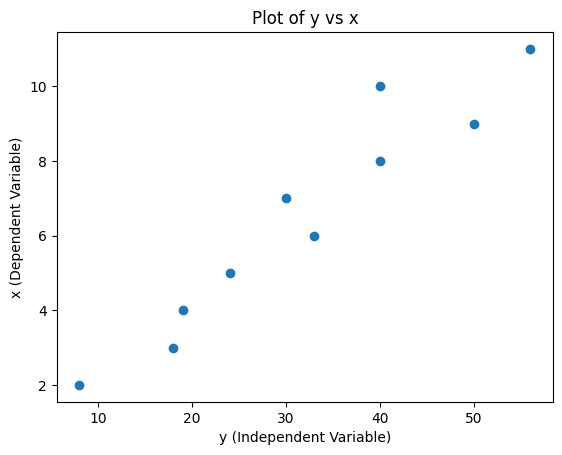

In [19]:
plt.scatter(y, x)
plt.xlabel("y (Independent Variable)")
plt.ylabel("x (Dependent Variable)")
plt.title("Plot of y vs x")
plt.show()

Seems to be linear.

*Residuals analysis*

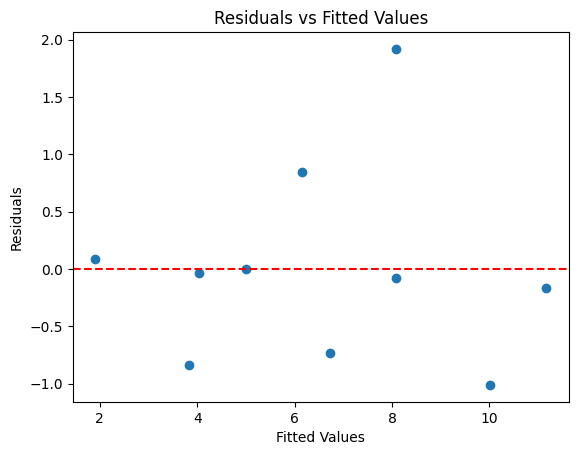

In [20]:
Y_const = sm.add_constant(y)
model_2 = sm.OLS(x, Y_const).fit()
fitted_values = model_2.predict(Y_const)
residuals = model_2.resid

plt.scatter(fitted_values, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

The data have linear relationship. 

In [21]:
n = Y.shape[0]
p = 2 
H = Y@np.linalg.inv(Y.T@Y)@Y.T

temp=0
standres = []
for res_i in residuals:
    standres.append(res_i/(np.sqrt(np.sum(residuals**2)*(1-np.diag(H)[temp])/(n-p))))
    temp+=1
    
standres = np.array(standres)

*The standardized residuals:*

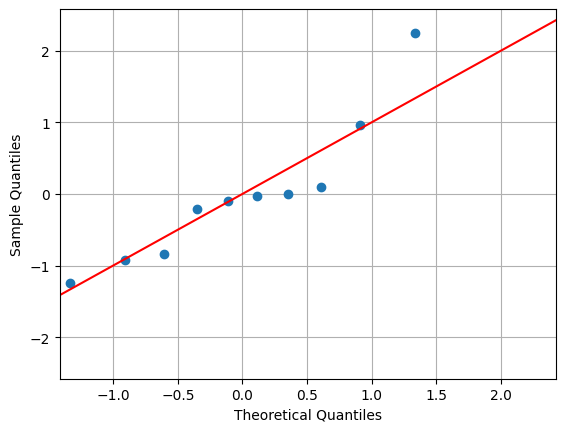

In [22]:
sm.qqplot(standres, line='45')
plt.ylim(-2.58,2.58)
plt.grid()
plt.show()

*The studentized residuals:*

In [23]:
temp = 0
t = []
s = []
for res_i in residuals:
    s_i = sum(residuals**2)/(n-p-1)-res_i**2/((n-p-1)*(1-np.diag(H)[temp]))
    s.append(s_i)
    t.append(res_i/(np.sqrt(s_i*(1-np.diag(H)[temp]))))
    temp+=1 

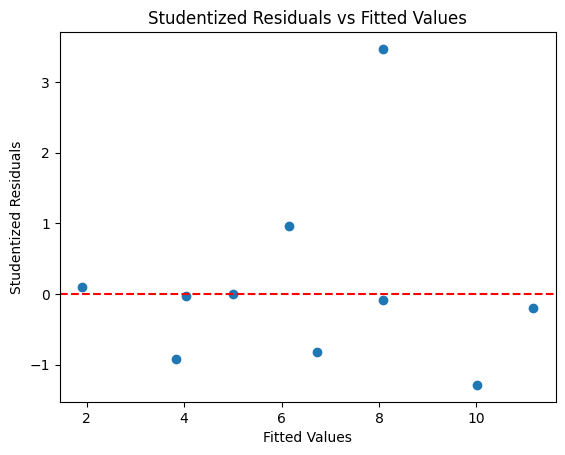

In [24]:
plt.scatter(fitted_values, t)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Studentized Residuals")
plt.title("Studentized Residuals vs Fitted Values")
plt.show()

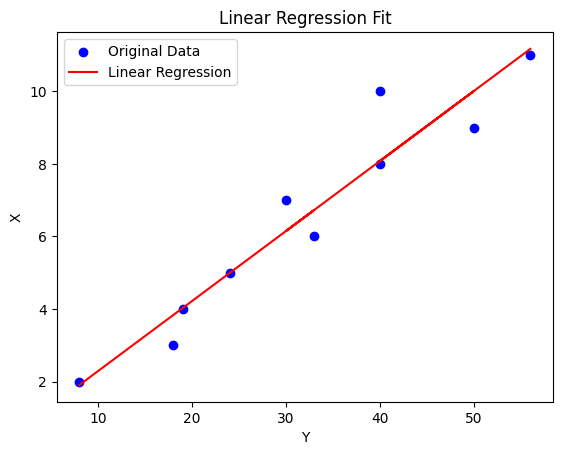

In [25]:
plt.scatter(Y, X, color='blue', label='Original Data')
plt.plot(Y, fitted_values, color='red', label='Linear Regression')

plt.title('Linear Regression Fit')
plt.xlabel('Y')
plt.ylabel('X')
plt.legend()
plt.show()

In [26]:
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     90.50
Date:                Mon, 18 Sep 2023   Prob (F-statistic):           1.23e-05
Time:                        11:53:32   Log-Likelihood:                -12.187
No. Observations:                  10   AIC:                             28.37
Df Residuals:                       8   BIC:                             28.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3666      0.707      0.519      0.6

The procedure and analysis used in this section mirrors that of Question 1. Consequently, the linear relationship derived when 'y' is the independent variable is given by $x=0.3666+0.1929y$.

## Question 3:

In [27]:
x_vals = np.array([5.5,13.5])
X_const = sm.add_constant(x_vals)
predicted_vals = model_1.predict(X_const)

In [28]:
print(f"The predicted value y for x={x_vals[0]:.2f} is {predicted_vals[0]:.2f} and for x={x_vals[1]:.2f} is {predicted_vals[1]:.2f}")

The predicted value y for x=5.50 is 27.04 and for x=13.50 is 65.15


## Question 4:

In [29]:
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     90.50
Date:                Mon, 18 Sep 2023   Prob (F-statistic):           1.23e-05
Time:                        11:53:32   Log-Likelihood:                -28.221
No. Observations:                  10   AIC:                             60.44
Df Residuals:                       8   BIC:                             61.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8364      3.558      0.235      0.8

The coefficient of determination, often denoted as $R^2$, provides an indication of the goodness of fit of a particular regression model. Essentially, it represents the fraction of the dependent variable's variance that is explained by the independent variables.

Within the stats output, an $R^2$ value of 0.919 suggests that a staggering 91.9% of the variance in the dependent variable is accounted for by our regression model. Such a high $R^2$ value is indicative of a strong correlation, leaving a part of 9.1% of the values unexplained by the model.

# **Exercise 3**

Twenty teams of 4 individuals in each team played the "prisoner's dilemma" game 30 times. Each time each individual had to choose between either the "competitive" or the "cooperative" choice. For each team, the number of "cooperative" choices selected by the team members out of the total of 120 choices was recorded, as shown in the following table:

$$
\begin{array}{|c|c|c|}
\hline
 & \textbf{Male} & \textbf{Female} \\
\hline
\textbf{Public choice} & 49 & 64 \\
 & 37 & 52 \\
 & 68 & 54 \\
 & 61 & 79 \\
 & 64 & 29 \\
\hline
\textbf{Secret choice} & 27 & 58 \\
 & 52 & 41 \\
 & 30 & 40 \\
 & 39 & 44 \\
 & 34 & 44 \\
\hline
\end{array}
$$

Ten of the teams recorded their choices while keeping them secret. The other ten teams made their choices and announced them publicly (the choices of the individuals became known to the other individuals). Also, ten of the teams consisted only of men and the remaining ten of the teams consisted only of women.

It is given that the number of "cooperative" choices made by the team members follows the normal distribution with the same variance in all cases. What conclusions can you draw about the effect of the selection condition and gender on cooperation? Is there a significant interaction between the selection condition and gender? It is given that the level of significance is equal to 5%.

## Solution

*Variability between groups and within groups*

A two-way ANOVA can be used to analyze the effect of gender (factor A) and selection condition (factor B) on cooperative choices, as well as their interaction. This tests if the mean cooperative choices differ between:

- Levels of gender (male, female) (A)
- Levels of selection condition (public, secret) (B)
- Combinations of gender and selection condition

Three F-ratios are computed to discern how much of the dependent variable's variability can be linked to each effect and the interaction:

- ​$F_A = \frac{Variance from the main effect of A}{Error Variance}$ 

Variability due to factor A's main effect.

- $F_B = \frac{Variance from the main effect of B}{Error Variance}$

Variability due to factor B's main effect.

- $F_{AxB} = \frac{Variance from the AxB interaction effect}{Error Variance}$

Variability due to the interaction between A and B.

If the p-value for a specific factor is less than 0.05, that factor has a significant main effect. To determine the group that differs significantly, we review the mean values for that factor's levels. For interactions, if the p-value is above 0.05, it suggests that differences in the results of one factor aren't contingent on the levels of the other factor.

*Assumptions for the application of the Two-way ANOVA:*

- Independence : The observations are independent (that is, there is no relationship either between the observations of the different groups or between the observations within the same group).
- Normality : 
The observations of each cell come from populations that follow the normal distribution.
- Equality of variances : 
The distributions of the populations of each cell have equal variances.

The data meets the normality and equal variance assumptions, as the "cooperative" choices across all instances. Given that each team consists of 4 distinct members, with no overlap, and considering their individual "cooperative" choices, it's evident that the samples are independent. Therefore, all prerequisites for a two-way ANOVA are satisfied.

*The Two-way ANOVA is performed :* 

With replication, that is with more than one observations for every combination of the levels of the independent variables.

*Null hypotheses of the Two-way ANOVA with replication:*

The Two-way ANOVA with replication includes testing of the following three null hypotheses: 
- The mean values grouped by the levels of the first factor Α are equal. $(H_0: μ_{Α1}=μ_{Α2})$ were $A_1$ is the "Male"and $A_2$ is "Female".
- The mean values grouped by the levels of the second factor B are equal. $(H_0: μ_{B1}=μ_{B2})$ were $B_1$ is the "Public choise"and $B_2$ is "Secret choise".
- There is no interaction between the two factors.
This test informs us if the effect of a factor depends on the other factor.

Since we have 5 observations for each combination of the levels of the independent variables, we perform the Two-way ANOVA with replication.

In [30]:
male_public = [49, 37, 68, 61, 64]
female_public = [64, 52, 54, 79, 29]
male_secret = [27, 52, 30, 39, 34]
female_secret = [58, 41, 40, 44, 44]

df = pd.DataFrame({
    'Gender': ['Male']*5 + ['Female']*5 + ['Male']*5 + ['Female']*5,
    'Choice_Type': ['Public']*10 + ['Secret']*10,
    'Cooperative_Choice': male_public + female_public + male_secret + female_secret
})

df

,Gender,Choice_Type,Cooperative_Choice
0,Male,Public,49
1,Male,Public,37
2,Male,Public,68
3,Male,Public,61
4,Male,Public,64
5,Female,Public,64
6,Female,Public,52
7,Female,Public,54
8,Female,Public,79
9,Female,Public,29


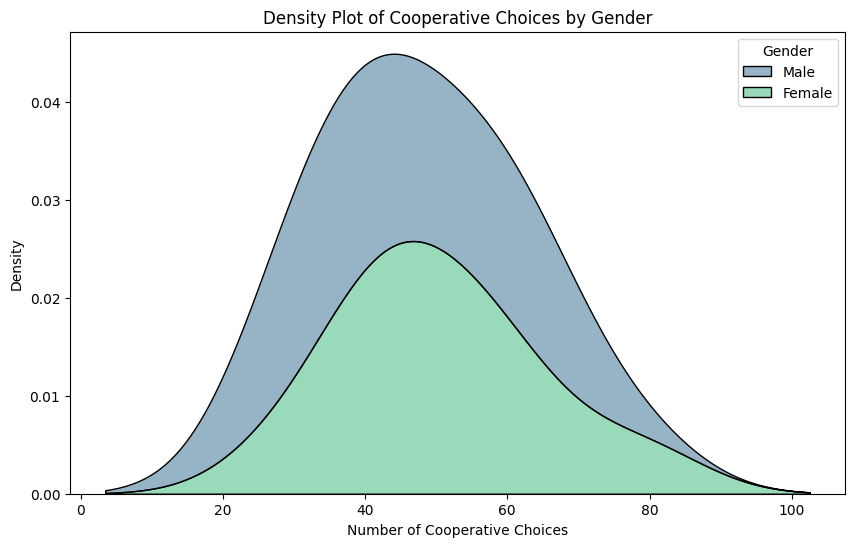

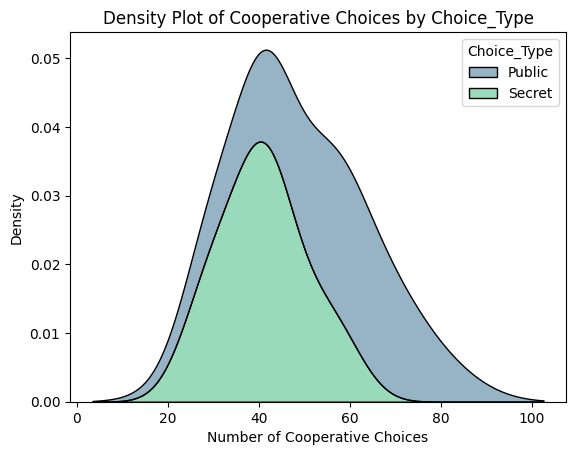

In [31]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="Cooperative_Choice", hue="Gender", multiple="stack", common_norm=False, fill=True, palette="viridis", alpha=0.5)

plt.title("Density Plot of Cooperative Choices by Gender")
plt.xlabel("Number of Cooperative Choices")
plt.ylabel("Density")

plt.show()

sns.kdeplot(data=df, x="Cooperative_Choice", hue="Choice_Type", multiple="stack", common_norm=False, fill=True, palette="viridis", alpha=0.5)

plt.title("Density Plot of Cooperative Choices by Choice_Type")
plt.xlabel("Number of Cooperative Choices")
plt.ylabel("Density")

plt.show()

The formula table of the two way anova is:

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\textbf{Source of Variation} & \textbf{d.f.} & \textbf{SumSq} & \textbf{MS} & \textbf{F} & \textbf{p-value} \\
\hline
\textbf{Gender} & df_A=a-1 & SS_A & MS_A=\frac{SS_A}{df_A} & \frac{MS_A}{MS_E} & \text{pvalue of } H_{A0} \\
\hline
\textbf{Choice} & df_B=b-1 & SS_B & MS_B=\frac{SS_B}{df_B} & \frac{MS_B}{MS_E} & \text{pvalue of } H_{B0} \\
\hline
\textbf{Gender \& Choice Interaction} & df_{AB}=(a-1)(b-1) & SS_{AB} & MS_{AB}=\frac{SS_{AB}}{df_{AB}} & \frac{MS_{AB}}{MS_E} & \text{pvalue of } H_{AB0} \\
\hline
\textbf{Error} & df_e=ab(n-1) & SS_e & MS_e=\frac{SS_e}{df_e} & & \\
\hline
\end{array}
$$

Were A = Genes Factor, B = Choise Factor.

In [32]:
model = ols('Cooperative_Choice ~ C(Gender) + C(Choice_Type) + C(Gender):C(Choice_Type)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                          sum_sq    df         F    PR(>F)
C(Gender)                   96.8   1.0  0.600217  0.449794
C(Choice_Type)            1095.2   1.0  6.790885  0.019109
C(Gender):C(Choice_Type)   105.8   1.0  0.656022  0.429850
Residual                  2580.4  16.0       NaN       NaN


*Results*

- Effect of Gender on Cooperation:

The F-statistic for Gender is $F=0.600217$
The p-value for Gender is $PR(>F)=0.449794$
Since the p-value for Gender is greater than the significance level of 0.05 we fail to reject the null hypothesis. This suggests that there is no significant main effect of Gender on the cooperative choices made.

- Effect of Selection Condition (Choice_Type) on Cooperation:

The F-statistic for Choice_Type is $F=6.790885$
The p-value for Choice_Type is $PR(>F)=0.019109$
Given that the p-value for Choice type is less than the significance level of 0.05 we reject the null hypothesis. This means that there is a significant main effect of the selection condition (whether the choice was made publicly or in secret) on the cooperative choices made.

- Interaction Effect between Gender and Selection Condition on Cooperation:

The F-statistic for the interaction between Gender and Choice type is $F=0.656022$
The p-value for this interaction is $PR(>F)=0.4298504$
The p-value for the interaction between Gender and Choice type is greater than the significance level of 0.05. Hence, we fail to reject the null hypothesis. This suggests that there isn't a significant interaction effect between Gender and the selection condition on the cooperative choices made.

*In Conclusion*

Based on the data and at the 5% level of significance, the main effect that drives cooperation appears to be the selection condition (whether the decision was made publicly or in secret) and not the gender of the participants. The two factors, Gender and Selection Condition, do not significantly interact to affect cooperative choices.

# **Exercise 4**

Six characteristics X1, X2, X3, X4, X5 and Y are measured simultaneously in fifty patients during a medical study. The measurements are recorded in the following table:

$$
\begin{array}{|c|c|c|c|c|c|c|}
\hline
s/n & \Upsilon & \Chi_1 & \Chi_2 & \Chi_3 & \Chi_4 & \Chi_5 \\
\hline
1 & 15,2 & 3,1 & 3,5 & 2,0 & 1,3 & 1 \\
2 & 16,3 & 2,9 & 3,0 & 2,1 & 1,2 & 1 \\
3 & 30,2 & 1,7 & 3,2 & 3,9 & 1,2 & 2 \\
4 & 12,5 & 2,6 & 3,1 & 2,5 & 1,3 & 1 \\
5 & 26,9 & 1,7 & 3,6 & 3,5 & 1,2 & 2 \\
6 & 35,2 & 1,8 & 3,4 & 3,6 & 1,2 & 2 \\
7 & 29,6 & 2,8 & 4,1 & 3,3 & 1,3 & 3 \\
8 & 23,0 & 2,5 & 3,8 & 2,5 & 1,1 & 2 \\
9 & 15,8 & 3,2 & 3,2 & 3,1 & 1,3 & 1 \\
10 & 24,0 & 2,7 & 4,0 & 4,9 & 1,3 & 2 \\
11 & 21,2 & 2,6 & 3,0 & 3,7 & 1,3 & 3 \\
12 & 15,2 & 3,0 & 3,6 & 2,3 & 1,2 & 1 \\
13 & 13,4 & 3,0 & 3,2 & 2,4 & 1,1 & 1 \\
14 & 17,0 & 2,8 & 3,2 & 2,3 & 1,3 & 1 \\
15 & 14,0 & 2,9 & 3,3 & 2,0 & 1,3 & 1 \\
16 & 14,0 & 2,7 & 3,3 & 2,5 & 1,1 & 2 \\
17 & 24,0 & 2,8 & 3,9 & 3,2 & 1,2 & 2 \\
18 & 16,8 & 3,7 & 4,1 & 2,8 & 1,2 & 2 \\
19 & 35,0 & 2,1 & 5,2 & 5,0 & 1,2 & 4 \\
20 & 32,7 & 2,2 & 3,0 & 3,9 & 1,2 & 3 \\
21 & 38,0 & 1,9 & 3,8 & 3,9 & 1,1 & 3 \\
22 & 37,0 & 1,3 & 3,4 & 4,5 & 1,2 & 2 \\
23 & 45,0 & 1,8 & 3,5 & 4,3 & 1,3 & 3 \\
24 & 23,7 & 2,5 & 4,0 & 4,5 & 1,3 & 3 \\
25 & 12,0 & 3,4 & 2,3 & 2,4 & 1,1 & 1\\
26 & 14,9 & 4,9 & 2,6 & 2,1 & 1,5 & 1 \\
27 & 25,6 & 2,9 & 3,0 & 3,1 & 1,4 & 2 \\
28 & 27,0 & 2,3 & 3,0 & 2,9 & 1,2 & 2 \\
29 & 33,7 & 2,3 & 2,4 & 2,8 & 1,9 & 2 \\
30 & 38,6 & 2,5 & 4,2 & 3,2 & 1,8 & 3 \\
31 & 31,5 & 2,3 & 3,1 & 3,0 & 1,6 & 2 \\
32 & 38,4 & 2,3 & 4,5 & 4,0 & 1,8 & 3 \\
33 & 25,5 & 3,2 & 3,0 & 3,3 & 1,4 & 2 \\
34 & 23,7 & 3,7 & 2,0 & 3,1 & 1,4 & 2 \\
35 & 22,1 & 3,0 & 3,5 & 2,9 & 1,3 & 2 \\
36 & 24,7 & 3,7 & 3,3 & 2,3 & 2,2 & 3 \\
37 & 33,8 & 3,0 & 2,0 & 3,4 & 1,7 & 2 \\
38 & 23,8 & 4,3 & 2,6 & 2,0 & 1,7 & 2 \\
39 & 39,4 & 3,5 & 3,9 & 5,5 & 1,8 & 4 \\
40 & 24,8 & 3,9 & 3,6 & 4,6 & 2,4 & 3 \\
41 & 34,8 & 4,6 & 4,8 & 3,4 & 2,4 & 3 \\
42 & 27,6 & 3,5 & 3,4 & 2,6 & 2,4 & 3 \\
43 & 26,3 & 3,6 & 2,4 & 2,8 & 2,2 & 3 \\
44 & 14,5 & 6,2 & 2,5 & 1,6 & 1,7 & 1 \\
45 & 13,8 & 7,0 & 2,1 & 1,7 & 1,8 & 1 \\
46 & 19,5 & 4,6 & 3,3 & 1,9 & 2,2 & 3 \\
47 & 30,2 & 3,7 & 3,0 & 2,4 & 1,8 & 2 \\
48 & 35,2 & 2,9 & 3,2 & 2,5 & 2,2 & 3 \\
49 & 28,0 & 3,0 & 3,1 & 3,0 & 1,8 & 2 \\
50 & 27,8 & 3,4 & 3,2 & 2,5 & 1,9 & 2 \\
\hline
\end{array}
$$

1) Perform a Principal Component Analysis (PCA) using the variables X1, X2, X3, X4 and X5 to determine:
  i) The smallest number of Principal Components that describe at least 80% of the total variability.
  ii) The coordinates of each of the Principal Components of the question i. with respect to the initial variables.
  iii) The coordinates of the data in the above table in the coordinates system defined by the Principal Components of the question i.
It is given that the assumptions required to apply PCA are valid.
2) Next, find the coefficients of the multiple linear regression model of the variable Y of the above table taking as independent variables the Principal Components of the question A.i. It is given that the assumptions required for the application of the multiple linear regression model are valid.

## Quesstion 1

Principal Component Analysis (PCA) is a technique used for dimensionality reduction and feature extraction. It transforms the original variables into a new set of orthogonal variables (the principal components) that capture the variance in the data. The first principal component captures the most variance, the second captures the second most, and so on.

PCA involves computing the eigenvectors and eigenvalues of the covariance matrix of the data. The eigenvectors (principal components) are the directions of the axes where there is the most variance (most information), and eigenvalues represent the magnitude of this variance.

Given the problem, we were tasked with analyzing five measurements from fifty patients, labeled as X1, X2, X3, X4, and X5.

In this step, we use the sklearn library's PCA function. Before applying PCA, it's crucial to scale the data (mean = 0, standard deviation = 1). However, the question states that the assumptions for PCA were already valid, so we proceeded directly with the PCA.

In [33]:
data = {
    'Χ1': [3.1, 2.9, 1.7, 2.6, 1.7, 1.8, 2.8, 2.5, 3.2, 2.7,
           2.6, 3.0, 3.0, 2.8, 2.9, 2.7, 2.8, 3.7, 2.1, 2.2,
           1.9, 1.3, 1.8, 2.5, 3.4, 4.9, 2.9, 2.3, 2.3, 2.5,
           2.3, 2.3, 3.2, 3.7, 3.0, 3.7, 3.0, 4.3, 3.5, 3.9,
           4.6, 3.5, 3.6, 6.2, 7.0, 4.6, 3.7, 2.9, 3.0, 3.4],
    'Χ2': [3.5, 3.0, 3.2, 3.1, 3.6, 3.4, 4.1, 3.8, 3.2, 4.0,
           3.0, 3.6, 3.2, 3.2, 3.3, 3.3, 3.9, 4.1, 5.2, 3.0,
           3.8, 3.4, 3.5, 4.0, 2.3, 2.6, 3.0, 3.0, 2.4, 4.2,
           3.1, 4.5, 3.0, 2.0, 3.5, 3.3, 2.0, 2.6, 3.9, 3.6,
           4.8, 3.4, 2.4, 2.5, 2.1, 3.3, 3.0, 3.2, 3.1, 3.2],
    'Χ3': [2.0, 2.1, 3.9, 2.5, 3.5, 3.6, 3.3, 2.5, 3.1, 4.9,
           3.7, 2.3, 2.4, 2.3, 2.0, 2.5, 3.2, 2.8, 5.0, 3.9,
           3.9, 4.5, 4.3, 4.5, 2.4, 2.1, 3.1, 2.9, 2.8, 3.2,
           3.0, 4.0, 3.3, 3.1, 2.9, 2.3, 3.4, 2.0, 5.5, 4.6,
           3.4, 2.6, 2.8, 1.6, 1.7, 1.9, 2.4, 2.5, 3.0, 2.5],
    'Χ4': [1.3, 1.2, 1.2, 1.3, 1.2, 1.2, 1.3, 1.1, 1.3, 1.3,
           1.3, 1.2, 1.1, 1.3, 1.3, 1.1, 1.2, 1.2, 1.2, 1.2,
           1.1, 1.2, 1.3, 1.3, 1.1, 1.5, 1.4, 1.2, 1.9, 1.8,
           1.6, 1.8, 1.4, 1.4, 1.3, 2.2, 1.7, 1.7, 1.8, 2.4,
           2.4, 2.4, 2.2, 1.7, 1.8, 2.2, 1.8, 2.2, 1.8, 1.9],
    'Χ5': [1, 1, 2, 1, 2, 2, 3, 2, 1, 2,
           3, 1, 1, 1, 1, 2, 2, 2, 4, 3,
           3, 2, 3, 3, 1, 1, 2, 2, 2, 3,
           2, 3, 2, 2, 2, 3, 2, 2, 4, 3,
           3, 3, 3, 1, 1, 3, 2, 3, 2, 2]
}

df = pd.DataFrame(data)
print(df.shape)
print(df.head())

(50, 5)
    Χ1   Χ2   Χ3   Χ4  Χ5
0  3.1  3.5  2.0  1.3   1
1  2.9  3.0  2.1  1.2   1
2  1.7  3.2  3.9  1.2   2
3  2.6  3.1  2.5  1.3   1
4  1.7  3.6  3.5  1.2   2


### I) Find number of components for 80% variance

In [34]:
pca = PCA()
pca.fit(df)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.where(cumulative_variance > 0.8)[0][0] + 1

print(f"Number of components for >= 80% variance: {num_components}")

Number of components for >= 80% variance: 2


Each principal component explains a percentage of the total variation in the dataset. We wanted to know how many components are required to describe at least 80% of the variability. The explained_variance_ratio_ provides the percentage of variance explained by each component. We use a cumulative sum to find when the sum surpasses 80%.

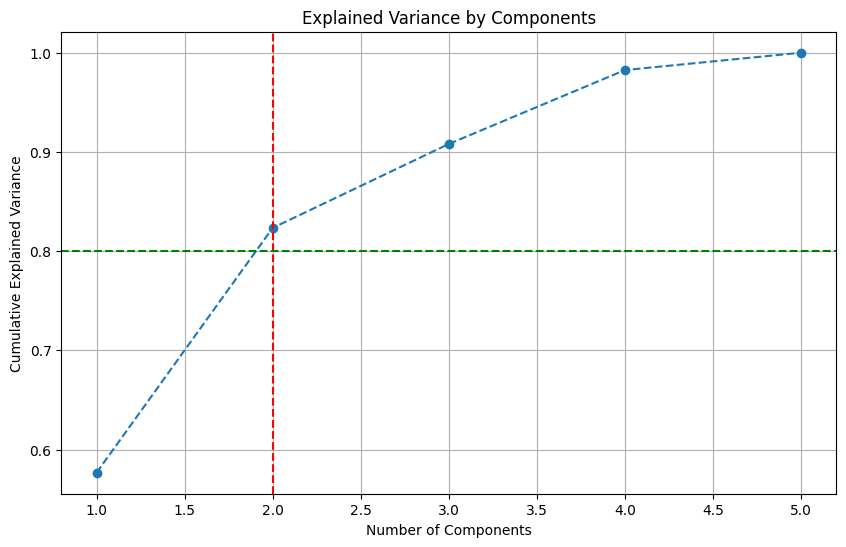

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title("Explained Variance by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.axvline(x=num_components, color='r', linestyle='--')
plt.axhline(y=0.8, color='g', linestyle='--')
plt.show()

### II) Coordinates with respect to initial variables

Loadings represent how much each feature contributes to each principal component. The loadings matrix has a shape of 5x5 because we have 5 original variables and 5 principal components. The magnitude and sign of the loading indicate the correlation with the principal component.

As the variables become more correlated, the length of the main axis (first eigenvalue) of the ellipsoid increases.

In [36]:
loadings = pca.components_

first_two_pc_loadings = loadings[:2, :]
# print(f"Loadings:\n{loadings}")

first_two_pc_loadings

array([[ 0.6222056 , -0.3122432 , -0.58503694,  0.05798617, -0.41198758],
       [ 0.67819152,  0.17960708,  0.2357698 ,  0.30969952,  0.59690566]])

\begin{align*}
\text{PC1:} \quad & 0.6222056 \times X1 - 0.3122432 \times X2 - 0.58503694 \times X3 + 0.05798617 \times X4 - 0.41198758 \times X5 \\
\text{PC2:} \quad & 0.67819152 \times X1 + 0.17960708 \times X2 + 0.2357698 \times X3 + 0.30969952 \times X4 + 0.59690566 \times X5 \\
\end{align*}

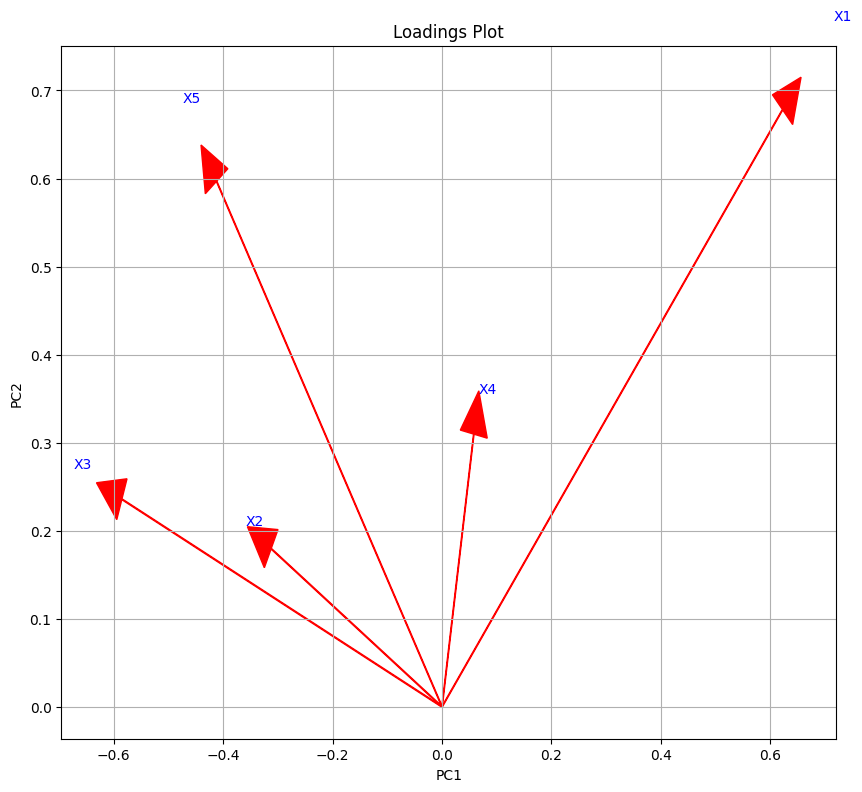

In [37]:
labels = ['X1', 'X2', 'X3', 'X4', 'X5']

plt.figure(figsize=(10,9))

for i, label in enumerate(labels):
    plt.arrow(0, 0, loadings[0,i], loadings[1,i], head_width=0.05, head_length=0.05, fc='red', ec='red')
    plt.text(first_two_pc_loadings[0,i]*1.15, first_two_pc_loadings[1,i]*1.15, label, color='blue')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Loadings Plot")
plt.grid()
plt.show()

### III) Transform the dataset to the new coordinate system


The transform method transforms the original data into the principal component space. For our specific query, we only wanted the data coordinates for the number of components that explained at least 80% of the variance.

In [38]:
transformed_data = pca.transform(df)

df_transformed = pd.DataFrame(transformed_data[:, :num_components], columns=[f'PC{i+1}' for i in range(num_components)])

print(df_transformed.head())

        PC1       PC2
0  1.037732 -0.953775
1  1.005110 -1.186610
2 -1.269039 -0.943227
3  0.559008 -1.246828
4 -1.159922 -0.965692


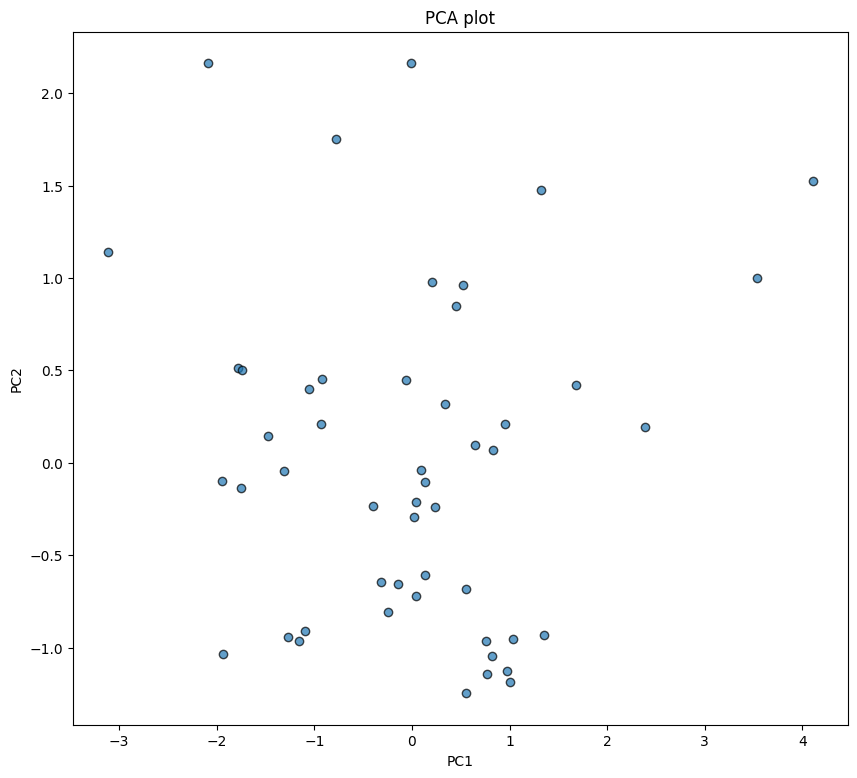

In [39]:
plt.figure(figsize=(10, 9))
plt.scatter(df_transformed['PC1'], df_transformed['PC2'], edgecolor='k', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA plot')
plt.show()

## Question 2

At first I will extract the principal components from *question 1i* and set the y labels.

In [40]:
df_transformed.shape

(50, 2)

In [41]:
y = np.array([15.2, 16.3, 30.2, 12.5, 26.9, 35.2, 29.6, 23.0, 15.8, 24.0,
    21.2, 15.2, 13.4, 17.0, 14.0, 14.0, 24.0, 16.8, 35.0, 32.7,
    38.0, 37.0, 45.0, 23.7, 12.0, 14.9, 25.6, 27.0, 33.7, 38.6,
    31.5, 38.4, 25.5, 23.7, 22.1, 24.7, 33.8, 23.8, 39.4, 24.8,
    34.8, 27.6, 26.3, 14.5, 13.8, 19.5, 30.2, 35.2, 28.0, 27.8])

In multiple linear regression, the equation in this occation is: 

$y=b_0+b_1x_1+b_2x_2$

$b_0$ is the intercept. It represents the expected value of y when all X values are 0. Essentially, it's the point where the regression line crosses the Y-axis.

$b_1, b_2$ are the coefficients of the predictors $x_1, x_2$. They represent the change in the dependent variable for a one-unit change in the predictor, holding all other predictors constant.

In [42]:
model = LinearRegression().fit(df_transformed, y)

coefficients = model.coef_
intercept = model.intercept_

In [43]:
print("Intercept:", intercept)
print("Coefficients:")
for i, coef in enumerate(coefficients, 1):
    print(f"PC{i}: {coef}")

Intercept: 25.458
Coefficients:
PC1: -4.405156661501753
PC2: 2.600305331317781


When visualizing this in 3D space:

The x and y-axes represent our predictors (PC1 and PC2).
The z-axis represents the dependent variable (y).
The plane is described by the intercept and coefficients, effectively demonstrating how the predictors combine to predict the dependent variable.
This plane is the best-fit plane that goes through the data in a way that minimizes the residuals.

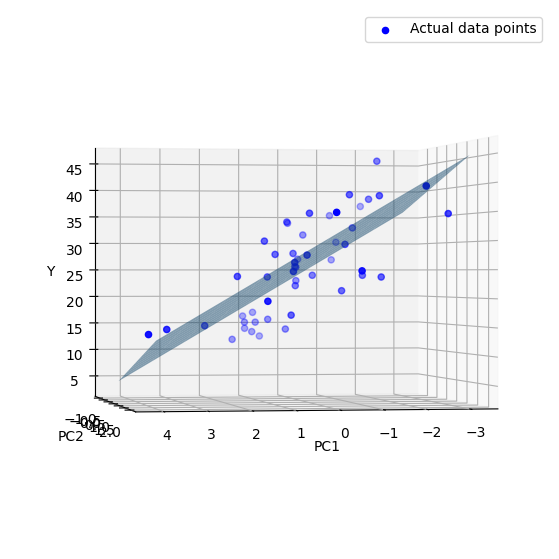

In [44]:
PC1 = df_transformed['PC1'].values
PC2 = df_transformed['PC2'].values
Y_actual = y

pc1_range = np.linspace(min(PC1), max(PC1), 10)
pc2_range = np.linspace(min(PC2), max(PC2), 10)
pc1_grid, pc2_grid = np.meshgrid(pc1_range, pc2_range)

Y_predicted = intercept + coefficients[0] * pc1_grid + coefficients[1] * pc2_grid

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(PC1, PC2, Y_actual, c='b', marker='o', label="Actual data points")
ax.plot_surface(pc1_grid, pc2_grid, Y_predicted, alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Y')
ax.view_init(elev=0, azim=80)
ax.legend()
plt.show()

# **Εxercise 5**

"Direct interaction: A strong heart results to a "strong" brain shows a scientific research
Keeping your heart in a good condition also helps your brain slowing down its aging process, according to a new US scientific study. The study found that healthy people who had "slow" hearts that pumped less blood, also had older brains than other people.
According to the BBC, in a study published in the medical journal “Circulation”, researchers at the University of Boston, led by Dr. Angela Jefferson, studied 1,500 people and, as they reported, a moderate performance of the heart results in a brain older about two years on average.
This finding applies even to young people, in the third decade of life, who did not have any heart disease, as well as to older people who had such diseases.
The researchers estimated that about the one third of the people in their sample, had a low heart rate and at the same time - as discovered from the relevant functional MRI scans - smaller brain volume (the brain shrinks as it becomes older).
People with smaller brain volume showed no obvious clinical signs of reduced brain function, but researchers believe that the brain shrinkage is an early sign of a future problem (eg dementia).
There are various theories as to why the reduced amount of blood pumped by the heart with respect to a person's body weight affects the health of the brain. An explanation is that the reduction of blood flow in the brain reduces the amount of oxygen and nutrients that are carried to brain cells.
"It's still too early to give medical advice based on our research, but it does show that heart and brain health really go hand by hand," Dr. Jefferson said.
Experts believe that it will be difficult for a person to change the volume of blood pumped by his heart, without doing very intensive physical exercise."


Describe the way you think the above study was organized and carried out. In particular, analyze the following:
1) Which hypotheses were tested by the researchers?
2) What data were collected and used to test each one of the above hypotheses (question (1))?
3) Which methods were used to test each one of the above hypotheses? Justify your answer.
4) Which were the results of the application of the above methods according to the aforementioned summary?

## Question 1:

In this study, researchers aimed to investigate the potential correlation between heart performance and indicators of brain age. A sizable sample of 1,500 participants, significantly larger than 30, was employed, thereby making the central limit theorem applicable and suggesting a Gaussian distribution.

For the purpose of estimating brain age, the volume of the brain was used as a proxy. A smaller brain volume is indicative of an older brain age. The study posited the following hypotheses:

- Null Hypothesis ($H_0$): There is no significant difference in brain age (as indicated by brain volume) between individuals with slow heart rates and those with regular/strong heart rates.

- Alternative Hypothesis ($H_1$): Individuals with slow heart rates have an older brain age (as indicated by reduced brain volume) compared to those with regular/strong heart rates.

The specific hypotheses tested are contingent on the statistical test chosen by the researchers. The core essence of the hypotheses is outlined above. However, the hypotheses may vary when using certain tests, such as a t-test. I will analyse more the specific hypotheses in question 3, where I'll examine the methodologies adopted for hypothesis testing.

## Question 2:

To test the hypotheses centered on the potential correlation between heart performance and indicators of brain age, the following data were collected and used:

- Brain Volume: This served as a proxy for estimating brain age. A reduction in brain volume is indicative of an older brain age. Advanced techniques like MRI were used to obtain accurate measurements of participants' brain volumes. Also, data that indicates obvious clinical signs of reduced brain function were gathered in order to in order to observe the if the lower brain volume effects the brain function.

- Heart Performance Metrics: The article's mention of individuals with "slow hearts" or "moderate heart performance" implies that heart rate (or another related measure) was a key metric. The study likely categorized participants based on their heart rates, distinguishing those with slower heart rates from those with more regular or faster rates. This categorization could be based on beats per minute or another standardized measure of heart performance.

## Question 3:

Given the sample size of 1,500 participants, the central limit theorem suggests that the distribution of the sample approaches a Gaussian distribution. Moreover, considering the known influence of age on brain volume, it's logical that the researchers incorporated age data to benchmark individual brain volumes against age-specific norms. Based on these premises, the researchers likely followed these steps:

1) Assess the Correlation Between Patient Age and Heart Rate.

   Begin by examining the correlation between the patients' age and their heart rates. A positive correlation would suggest that younger patients tend to have slower heart rates. This phenomenon could be attributed to the potential for younger adults to be more physically active and athletically inclined than older individuals. As a result, younger adults might have a more conditioned cardiovascular system that requires fewer heart beats per minute during rest, enhancing their capacity to handle intense physical activities.

   Should a significant correlation be observed between age and heart rate, it's imperative to note that the classification of heart performance (slow vs. normal) might necessitate considering both age and heart rate for a more accurate representation.

2) Logistic Regression for Classifying Heart performance:

   To differentiate between 'slow' and 'normal' heart performances, logistic regression can be utilized. In this scenario:

   Predictors:

      - $X_1$ Heart Rate: This primary indicator provides a direct measure of heart performance and serves as a foundational metric for distinguishing 'slow' and 'normal' hearts.

      - Only when the correlation is both positive and statistically significant should we consider  $X_2$ the age of the patient as predictor. Specifically:

         Athletic Consideration: Younger individuals often have a naturally slower heart rate due to higher athletic tendencies compared to their older counterparts."

   Response Variable:

      $Y$: Heart performance Classification - A binary response where:
       - 0 indicates a "normal" heart performance.
       - 1 indicates an "slow" heart performance.

   By fitting a logistic regression model with the predictors $X_1$ (and $X_2$), we can estimate the probability that a heart performs "slower" given specific values of the predictors. The logistic function will output a value between 0 and 1, which can be thresholded (commonly at 0.5) to classify heart percformances into one of the two categories.

3) Assessing Normality:

   Before applying any parametric tests on the **heart performance groups**, it's crucial to determine whether the data from both "slow" and "normal" heart performance groups individually follow a normal distribution. The Jarque-Bera test can be employed separately for each heart performance group. This test evaluates if the skewness and kurtosis of a sample align with a normal distribution. By testing these groups individually, we can ensure that each dataset's underlying distribution is understood, which will guide the subsequent choice of statistical tests.

   **Brain volume**, as the primary dependent variable, should also have its distribution assessed. The Jarque-Bera test can be used to understand if brain volume data follow a normal distribution.


4) Parametric Tests (Assuming Normal Distribution):

   1) The two distinct populations that are both assumed to follow a normal distribution: one consisting of approximately 500 patients and the other with around 1000. Age is recognized as a potential confounder in our analysis, given its known association with brain volume. Younger individuals are typically expected to have larger brain volumes compared to older ones, making age a pivotal factor in our study.

      To compare these populations fairly, especially given the potential age biases in the "slow" heart population, we'll focus on the overlapping age range shared by both groups. When multiple patients from a population share the same age, the average brain volume for that age will be used as a representative value for that specific age within the population.

      Assuming both populations exhibit homogeneity of variance in their overlapping age range and adhere to the normal distribution, we can proceed with a one-sided t-test. This test aims to determine if the "slow" hearted group tends to have a lower mean brain volume compared to the other.

      Null Hypothesis:
      - $H_0$: The mean brain volume is the same for both the "slow" hearted group and the "normal" hearted group.

      Alternative Hypothesis:
      - $H_1$: The mean brain volume for the "slow" hearted group is lower than that of the "normal" hearted group.

      A limitation of this approach is the necessary consolidation of certain data points and exclusion of others. To ensure the populations are comparable for a one-sided t-test, we inadvertently reduce the dataset's size.

   2) Another approach to ensure data normality and independence involves constructing separate linear models and subsequently comparing them to discern potential differences. By utilizing an ANOVA table, it becomes feasible to determine statistically significant discrepancies between the models. By segregating the populations into 'slow' and 'normal' heart performance categories, we can develop two linear models, contingent on the fulfillment of the residual analysis assumptions. As these models employ patient age as a predictor to derive brain volume, our focus will be primarily on the coefficients and intercepts. Given the substantial data points available for each group, this analysis can provide insightful results.

      - Construct the Linear Models:
         - For 'slow' heart performance: $BrainVolume_{slow} = b_0+b_1Age$
         - For 'normal' heart performance: $BrainVolume_{normal} = a_0+a_1Age$

      - Combine the models:
         - For the combined model: $BrainVolume_{combined}=c_0+c_1Age+c_2Group+c_3Age*Group$





      Hypotheses for the 2-way MANOVA:

      - Main Effect - Heart Performance:

         - Null Hypothesis $H_0$: The mean brain volume is the same across both slow and normal heart performance groups.
         - Alternative Hypothesis $H_1$: The mean brain volume differs between the slow and normal heart performance groups.

      - Main Effect - Age:

         - Null Hypothesis $H_0$: The mean brain volume is the same across different age groups.
         - Alternative Hypothesis $H_1$: The mean brain volume varies with age.

      - Interaction Effect - Heart Performance x Age:

         - Null Hypothesis $H_0$: There's no interaction between heart performance and age in influencing brain volume.
         - Alternative Hypothesis $H_1$: The influence of heart performance on brain volume changes at different age levels.

      However, a potential limitation with ANOVA is its inability to specifically cater to one-sided tests, particularly since the researchers are primarily inclined to determine if the brain volume is smaller for those with slower heart rates, and not necessarily larger. Finally, the main effect of heart performance and the interaction effect indicate whether there is a relationship between heart performance and brain volume.

   2) If the data do not have Homogeneity of variances.
   Matching on Age:

Given the importance of brain age in the study, it's crucial to ensure both the "slow" hearted patients and "normal" hearted patients have similar age distributions. To achieve this, patients from both groups are matched based on their age, ensuring that there are equal numbers of patients of each age in both groups. This controls for age as a potential confounding variable.
Reduced Sample Size Consideration:

By employing this matching approach, the effective sample size will be reduced. This reduced dataset can affect the power of subsequent statistical tests. Care should be taken in interpreting results, keeping this limitation in mind.
Repeated Sampling:

To account for variability and ensure robustness of results, this matching and testing procedure can be repeated with different subsets of the data. Each iteration may yield slightly different results, so conclusions should consider the aggregate findings across iterations.
T-Test:

After forming the matched groups, the brain volumes of "slow" hearted and "normal" hearted patients can be compared using an independent samples t-test.
Hypotheses for the T-Test:

Brain Volume Comparison:
Null Hypothesis 
�
0
H 
0
​
 : The mean brain volume is the same for matched "slow" hearted and "normal" hearted patients.
Alternative Hypothesis 
�
1
H 
1
​
 : The mean brain volume differs between matched "slow" hearted and "normal" hearted patients.
Potential Drawbacks:

Loss of Information: By excluding unmatched participants, some valuable information might be left out.
T-Test As

3) Non-parametric Tests (If Data isn't Normally Distributed):

   Mann-Whitney U test or Wilcoxon rank-sum test: If the Jarque-Bera test indicates that our data does not follow a normal distribution, for the quantitative data these test can be used. It'll evaluate if there's a statistically significant difference in brain volume distributions between the two heart performance groups.

   The hypotheses of the Mann-Whitney U or Wilcoxon rank-sum test test would be:

   - Null Hypothesis ($H_0$): The distribution of brain volumes for the "slow" hearted patients is the same as for the "normal" hearted patients.
   - Alternative Hypothesis ($H_1$): The distribution of brain volumes for the "slow" hearted patients is lower than that of the "normal" hearted patients.

   Chi-squared test: If the Jarque-Bera test indicates that our data does not follow a normal distribution, an alternative approach would be to categorize the continuous data. In this context, we can group participants into categories based on their heart performance ("slow" vs. "normal") and their brain volume ("smaller" vs. "normal"). By transforming the data into these categorical bins, we can then create a table. Utilizing the Chi-squared test on this table will allow us to observe any potential associations or differences between the heart performance groups in relation to brain volume categories. However, converting continuous data to categorical form inevitably sacrifices a part of information and potentially hide insights about the populations. While this strategy simplifies the data, it may not always be the most effective approach for discerning subtle differences between groups.

   The hypotheses of the Chi-squared test would be:

   - Null Hypothesis ($H_0$): There is no association between heart performance and categorized brain volume.
   - Alternative Hypothesis ($H_1$): There is a significant association between heart performance and categorized brain volume.
